In [ ]:
%load_ext autoreload
%autoreload 2


from liftout.structures import Sample, load_experiment


import os 
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

sample = load_experiment(path)
sample.__to_dataframe__()

### Log Parsing (new)

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from copy import deepcopy
from dataclasses import dataclass

from pathlib import Path

from liftout.tools.data import calculate_statistics_dataframe, AutoLiftoutStatistics, calculate_aggregated_statistics


paths = [
    r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM",
    r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM"
]





In [ ]:
df = calculate_aggregated_statistics(paths)
display(df)

In [ ]:
# specimen current
microscope.state.specimen_current.value

## System Settings
Set / Restore system settings


In [ ]:
%load_ext autoreload
%autoreload 2
from fibsem import utils, calibration
from fibsem.structures import BeamSystemSettings, SystemSettings, BeamType

from autoscript_sdb_microscope_client import SdbMicroscopeClient

from pprint import pprint 

In [ ]:
microscope, settings = utils.setup_session()

In [ ]:
eb_settings = calibration.get_current_beam_system_state(microscope, BeamType.ELECTRON)
ib_settings = calibration.get_current_beam_system_state(microscope, BeamType.ION)
pprint(eb_settings)
pprint(ib_settings)

In [ ]:
from dataclasses import asdict
# check if settings are different
for i, (a, b) in enumerate(list(zip(asdict(eb_settings).values(), asdict(settings.system.electron).values()))):

    if a != b:
        k = list(asdict(eb_settings).keys())[i]
        print("not equal: ", k, a, b)

## History Bug

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import create_experiment, Lamella, AutoLiftoutStage
from liftout.autoliftout import update_sample_lamella_data
from fibsem import utils
from pprint import pprint
from liftout import autoliftout


microscope, settings = utils.setup_session()
os.makedirs("test", exist_ok=True)
sample = create_experiment("test-history", "test")


In [ ]:
lamella = Lamella(sample.path, 1)
sample = update_sample_lamella_data(sample, lamella)

stages = [stage for stage in AutoLiftoutStage][2:]

for stage in stages:
    print(stage)
    pprint(sample)
    pprint(sample.positions[1])

    lamella.current_state.stage = stage
    sample = autoliftout.end_of_stage_update(microscope, sample, lamella, )
    
    pprint(sample)
    pprint(sample.positions[1])
    pprint([state.stage.name for state in sample.positions[1].history])
    print("-"*50)

## Initial Calibration

Set the initial grid states 

set the initial calibration (eucentric, horizontal shift, needle)

## New AutoLiftout UI

autoliftout ui in napari


In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import load_experiment, Sample
from autoscript_sdb_microscope_client.structures import AdornedImage
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import napari
from liftout import autoliftout

# pprint(sample)


In [ ]:
DISPLAY_REFERENCE_FNAMES = [
    "ref_lamella_low_res_ib",
    "ref_trench_high_res_ib",
    "ref_jcut_high_res_ib",
    "ref_liftout_ib",
    "ref_landing_lamella_high_res_ib",
    "ref_reset_high_res_ib",
    "ref_thin_lamella_post_superres_ib",
    "ref_polish_lamella_post_superres_ib",
]

headers = [
    "Sample No",
    "Position",
    "Reference",
    "Milling",
    "J-Cut",
    "Liftout",
    "Landing",
    "Reset",
    "Thinning",
    "Polishing",
]

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(overview_image, cmap="gray")
plt.show()

In [ ]:
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)

# TODO: stage labels, lamella labels

overview_image = create_overview_image(sample)
viewer = napari.Viewer()
viewer.add_image(overview_image, name="AutoLiftout")

In [7]:

%load_ext autoreload
%autoreload 2

from fibsem import utils

microscope, settings = utils.setup_session(session_path = "xyz")

2022-10-06 11:01:26,777 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-06 11:01:26,782 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-06 11:01:26,783 — root — INFO — setup_session:252 — Finished setup for session: demo_2022-10-06.11-01-26AM


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


In [6]:
settings.image.save_path

'abc'

In [20]:
from gc import is_finalized
from liftout.structures import AutoLiftoutStage, load_experiment, Lamella, Sample

path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)


def get_completion_stats(sample: Sample) -> tuple:
    """Get the current completetion stats for lifout"""    
    n_stages = AutoLiftoutStage.Polishing.value # init and failure dont count

    lam: Lamella
    active_lam = 0
    completed_stages = 0
    for lam in sample.positions.values():

        # dont count failure
        if lam.is_failure or lam.current_state.stage.value == 99:
            continue
        
        active_lam += 1
        completed_stages += lam.current_state.stage.value

    total_stages = n_stages * active_lam
    perc_complete = completed_stages / total_stages


    return n_stages, active_lam, completed_stages, total_stages, perc_complete


n_stages, active_lam, completed_stages, total_stages, perc_complete = get_completion_stats(sample)

print(completed_stages, active_lam, total_stages, perc_complete)


5 2 14 0.35714285714285715


In [2]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
import matplotlib.pyplot as plt

microscope, settings = utils.setup_session()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-10-17 12:35:48,834 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-17 12:35:48,838 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-17 12:35:48,839 — root — INFO — setup_session:252 — Finished setup for session: demo_2022-10-17.12-35-48PM


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


2022-10-17 12:37:30,368 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-10-17 12:37:31,046 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-17 12:37:33,035 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -31.095 | 1.000
2022-10-17 12:37:33,067 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-10-17 12:37:33,916 — root — INFO — acquire_image:186 — acquiring new ION image.
2022-10-17 12:37:35,800 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Ion | 53.425 | 1.534


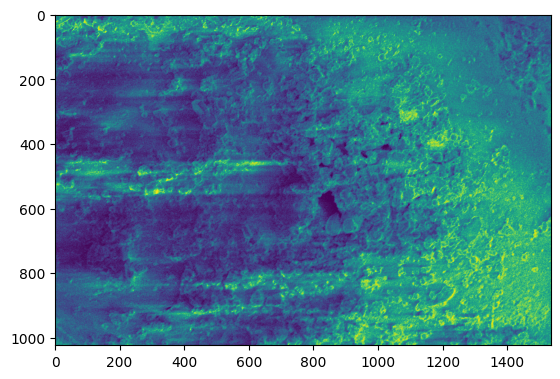

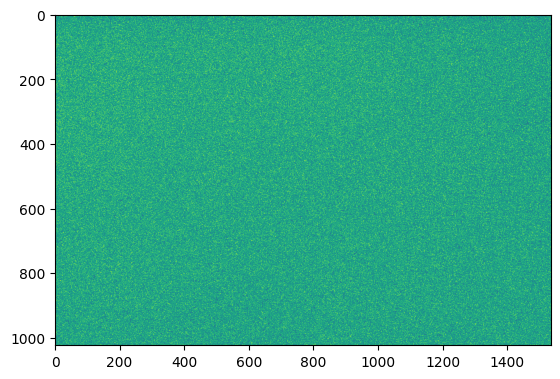

In [4]:
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

plt.imshow(eb_image.data)
plt.show()

plt.imshow(ib_image.data)
plt.show()

In [6]:
microscope.beams.ion_beam

1.0

In [15]:
microscope.beams.ion_beam.high_voltage.limits

Limits(min=2000, max=30000)